# Feature extraction

## Imports and data loading

In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from cycler import cycler
from sklearn.preprocessing import StandardScaler

import sys
sys.path.append("..")
from dissect.imu_feature_extraction import compute_feature_all


sr = 300.  # sampling rate, Hz

RGB = ["#D55E00", "#009E73", "#0072B2"]
RGB_CYCLER = cycler(color=RGB)

In [2]:
# Preprocessed IMU (see 00_preprocessing.ipynb)
imu = pd.read_pickle("../data_example/example_imu.pickle")
imu.head(5)

,ax,ay,az,gx,gy,gz,qx,qy,qz,qw,ax_G,ay_G,az_G,ax_R,ay_R,az_R
counter,,,,,,,,,,,,,,,,
703455,-0.437201,0.124428,0.529188,-51.788330,74.554443,15.106201,0.108667,0.330012,-0.038276,0.936920,-0.626708,0.178362,0.758567,0.189507,-0.053934,-0.229379
703456,-0.487250,0.114418,0.469129,-61.309814,59.326172,13.824463,0.110625,0.389789,-0.041640,0.913287,-0.721191,0.169602,0.671654,0.233941,-0.055184,-0.202525
703457,-0.593939,-0.029137,0.406385,-63.079834,46.936035,13.214111,0.329275,0.191478,-0.768666,0.513874,-0.702997,0.044046,0.709828,0.109057,-0.073183,-0.303443
703458,-0.818793,-0.141930,0.328016,-51.116943,38.574219,7.049561,0.386625,0.197573,-0.860031,0.268016,-0.770924,-0.132595,0.622973,-0.047869,-0.009335,-0.294957
703459,-1.048041,-0.175133,0.322156,-39.978027,27.465820,6.164551,0.413260,0.183231,-0.870297,0.195514,-0.790967,-0.157334,0.591285,-0.257075,-0.017799,-0.269129


In [3]:
# Precomputed change points (see 01_changepoint.ipynb)
chpt_df = pd.read_pickle("../data_example/example_chpt.pickle")
print(len(chpt_df))
chpt_df.head(5)

3294


,iloc_start,iloc_end
0,0,198
1,198,244
2,244,300
3,300,344
4,344,457


## Compute all features relying on the signals' statistics and AHRS filtering of the data

In [4]:
%%time
features = compute_feature_all(imu, chpt_df.iloc_end.values, sr=sr)
features.head(5)

CPU times: user 3min 23s, sys: 4.45 s, total: 3min 28s
Wall time: 19.6 s


,duration,duration_log10,gx_mean,gy_mean,gz_mean,ax_G_mean,ay_G_mean,az_G_mean,ax_R_mean,ay_R_mean,...,azimuth3d_speed,azimuth2d_cumulative_change,azimuth2d_cumulative_speed,azimuth2d_change_mean,azimuth2d_change_std,azimuth2d_change_min,azimuth2d_change_max,azimuth2d_change_p25,azimuth2d_change_median,azimuth2d_change_p75
0,0.660000,-0.180456,-6.283847,-7.425790,8.337618,-0.858151,-0.002136,0.509406,0.006600,-0.001709,...,124.801065,6.212065,9.412220,6.059199,2.539103,0.190710,8.898763,5.334605,7.174027,7.696399
1,0.153333,-0.814363,9.501582,-472.663548,34.122633,-0.191561,-0.002943,0.882835,0.048385,0.007185,...,523.298773,5.193212,33.868772,-0.876950,2.325896,-3.509091,5.193212,-2.803769,-1.439262,0.489726
2,0.186667,-0.728933,17.908914,5.161285,15.580314,0.498023,-0.038409,0.865547,-0.025447,-0.001060,...,24.175137,3.856314,20.658823,4.549894,0.967599,0.620489,5.235514,4.568945,4.827215,5.086856
3,0.146667,-0.833669,-38.132407,202.400208,-329.451127,0.189041,0.027026,0.968391,-0.007795,-0.140813,...,309.239416,-47.190286,-321.751953,-24.246075,14.697536,-47.190286,-0.513494,-37.662270,-24.195243,-11.537651
4,0.376667,-0.424043,25.971269,30.303685,-77.753388,-0.294186,0.020826,0.949658,-0.143683,0.064155,...,48.301650,-30.059363,-79.803619,-19.816479,11.639220,-32.102760,-0.639118,-31.235113,-23.049250,-7.302276


In [5]:
len(features)  # -> one row per segment

3294

## Compute features relying on time-frequency analysis of the data
**Warning** In the analyses presented in the article, we relied on an implementation in R for the continuous wavelet transform. For convenience, here is a pure python function for extracting these features but the exact resulting values might marginalget_linearly_spaced_cwtly differ from the ones in the feature dataframe used in the subsequent notebooks.

In [6]:
from dissect.time_frequency import compute_cwt, get_linearly_spaced_cwt, compute_feature_cwt

### Example full CWT transform

In [7]:
%%time
col = "gy"
W, f = compute_cwt(imu[col].values, sr=300.)
W_abs = np.abs(W)

CPU times: user 51.8 s, sys: 7.71 s, total: 59.5 s
Wall time: 4.44 s


Text(0.5, 1.0, 'Magnitude of CWT of gy, 1-20Hz')

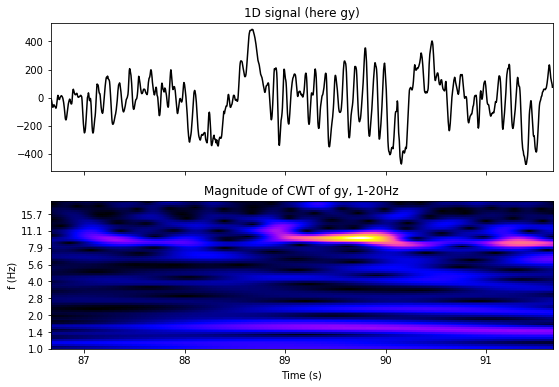

In [8]:
iloc_start = 26000
duration = 1500  # duration to plot, in IMU samples
iloc_end = iloc_start + duration - 1
time = np.arange(len(imu)) / sr
t_start, t_end = time[iloc_start], time[iloc_end]

fmin = 1
fmax = 20
f_is_selected = (f >= fmin) & (f < fmax)
f_selected = f[f_is_selected]

W_to_plot = pd.DataFrame(W_abs[iloc_start:iloc_end, f_is_selected], index=time[iloc_start:iloc_end], columns=f_selected)


fig, axs = plt.subplots(2, 1, figsize=(9, 6), sharex=True)

axs[0].plot(time[iloc_start:iloc_end], imu.iloc[iloc_start:iloc_end][col], c="k")

# axs[0].set_ylim([-600, 600])
#axs[0].set_ylabel(f"{col} (°/s)")
# axs[0].set_yticks([-500, -250, 0, 250, 500])

axs[1].imshow(W_to_plot.T, origin="lower", aspect="auto", extent=[t_start, t_end, 0, len(f_selected)], cmap="gnuplot2")
yticks_loc = np.arange(0, len(f_selected), 10)
yticks_labels = np.round(f_selected[yticks_loc], 1)
axs[1].set_yticks(yticks_loc)
axs[1].set_yticklabels(yticks_labels)
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("f (Hz)")

axs[0].set_title(f"1D signal (here {col})")
axs[1].set_title(f"Magnitude of CWT of {col}, {int(fmin)}-{int(fmax)}Hz")

### Linearly binned magnitude of CWT
The binning is done by averaging the magnitude of CWT coefficients in linearily-spaced frequency bands.

In [9]:
get_linearly_spaced_cwt(imu.gx, fmin=2.5, fmax=20, nbins=7, sr=300.)

,gx_2.5-5.0,gx_5.0-7.5,gx_7.5-10.0,gx_10.0-12.5,gx_12.5-15.0,gx_15.0-17.5,gx_17.5-20.0
counter,,,,,,,
703455,4.167901,4.796137,4.784883,10.843027,9.111785,2.972507,6.185513
703456,4.169178,4.797953,4.784290,10.841354,9.109918,2.979275,6.221848
703457,4.172270,4.802624,4.782508,10.836343,9.104320,2.999374,6.290556
703458,4.176282,4.809117,4.779541,10.827992,9.094993,3.032221,6.370702
703459,4.180789,4.816844,4.775394,10.816314,9.081942,3.076941,6.458825
...,...,...,...,...,...,...,...
1403902,10.923481,10.152374,5.269074,1.606396,1.930653,1.974058,0.408983
1403903,10.917189,10.138780,5.259077,1.594983,1.930088,1.973056,0.411762
1403904,10.912663,10.128806,5.251846,1.586583,1.929662,1.972347,0.413781


### Time-frequency features for the segments
For each aforementioned frequency bin, we compute the log-10 of the per-segment median coefficient value for all gyroscope and non-gravitational acceleration axes.

In [10]:
%%time
features_time_frequency = compute_feature_cwt(imu, chpt_df.iloc_end.values, sr=sr)

CPU times: user 5min 13s, sys: 47.4 s, total: 6min
Wall time: 28.3 s


In [11]:
features_time_frequency.head()

,ax_R_2.5-5.0,ax_R_5.0-7.5,ax_R_7.5-10.0,ax_R_10.0-12.5,ax_R_12.5-15.0,ax_R_15.0-17.5,ax_R_17.5-20.0,ay_R_2.5-5.0,ay_R_5.0-7.5,ay_R_7.5-10.0,...,gy_12.5-15.0,gy_15.0-17.5,gy_17.5-20.0,gz_2.5-5.0,gz_5.0-7.5,gz_7.5-10.0,gz_10.0-12.5,gz_12.5-15.0,gz_15.0-17.5,gz_17.5-20.0
0,-1.252849,-1.071391,-0.798275,-0.991744,-1.244629,-1.148918,-1.038319,-2.067305,-1.742287,-1.554034,...,1.127401,1.095178,1.192747,1.168438,1.096780,1.222810,1.079564,0.943180,0.958705,0.887251
1,-1.151131,-1.046716,-0.870357,-1.033493,-1.143967,-1.170840,-1.382178,-1.878470,-1.532018,-1.354119,...,0.888897,1.216664,0.736391,1.441255,1.372285,1.384887,1.377242,1.093714,1.079344,0.540377
2,-1.168045,-1.036567,-0.866187,-0.948495,-1.432634,-1.321083,-1.115698,-1.779161,-1.439097,-1.440153,...,1.112247,0.962414,1.048221,1.506970,1.534686,1.382890,1.258183,0.880058,0.870812,0.371749
3,-1.213772,-1.072698,-0.949718,-1.067438,-1.452740,-1.581092,-1.422456,-1.693416,-1.330847,-1.388288,...,1.269962,0.817531,1.036310,1.535231,1.681612,1.428796,1.131692,1.119167,1.118769,0.914029
4,-1.303535,-1.097975,-1.179983,-1.378737,-1.496712,-1.277482,-1.050037,-1.587148,-1.157907,-1.387726,...,1.228119,1.145252,1.174608,1.513578,1.727691,1.611720,1.280025,0.959368,1.197681,1.087420


In [12]:
# Total dimensionality of the features for each segment
features.shape[1] + features_time_frequency.shape[1]

240